1.1 Importing python libraries

In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.tree import Tree,ParentedTree 
from nltk.parse import stanford

import os
import pickle

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

1.2 Importing work files

In [2]:
# Please make sure you working files are in same folder where this python notebook is, else change the path accordingly.
text_file = open("wsj.22.mrg.text", "r")
gold_parser = open("wsj.22.mrg.gold", "r")
barkely_parser = open("wsj.22.mrg.berkeley", "r")

lines = text_file.readlines()
gold_lines = gold_parser.readlines()
barkely_lines = barkely_parser.readlines()

1.3 Defining function which locates the index span of tree node

In [3]:
def local_indexer(tree, root_tree, tree_left_index, tree_right_index):
    
    if tree.height()==root_tree.height():
        return tree_left_index, tree_right_index
    
    else:
        tree_left_index.insert(0, tree.parent_index())
        tree_right_index.insert(0, tree.parent_index())
        local_indexer(tree.parent(), root_tree, tree_left_index, tree_right_index)
        return tree_left_index, tree_right_index       

1.4 Defining function which gives the position of word in sentence, given its tree index

In [4]:
def local_positioner(tree, position_index):
    
    leaves = tree.leaves()
    leaves_length = len(leaves)
    
    for i in list(range(0,leaves_length)):
        if list(tree.leaf_treeposition(i)) == position_index:
            return i
        else:
            -1                

1.5 Defining function to produce python tree structure from work files

In [5]:
def tree_preprossing(tree):
    
    tree = ParentedTree.fromstring(tree)
    for sub in reversed(list(tree.subtrees())):
        if sub.height() == 2 and sub[0].startswith("*"):
            parent = sub.parent()
            while parent and len(parent) == 1:
                sub = parent
                parent = sub.parent()
            del tree[sub.treeposition()]
            
    for sub in (list(tree.subtrees())):
        _=sub.parent()
        try:
            if ((_.label() == 'TOP') | (_.label() == 'ROOT') | (_.label() == '')):
                tree = sub
        except:
            1  
    return tree        

1.6 Defining function to give stats for tree node: label - starting position - ending position

In [6]:
def tree_parser_stats(tree):
    
    tree_stats = []
    for sub in (list(tree.subtrees())):
        if sub.height() != 2:

            label = sub.label()

            leaves = sub.leaves()
            leaves_length = len(leaves)

            left_position_index, right_position_index = local_indexer(sub, tree, list(sub.leaf_treeposition(0)), list(sub.leaf_treeposition(leaves_length-1)))
            left_position = local_positioner(tree, left_position_index)
            right_position = local_positioner(tree, right_position_index)

            tree_stats.append(list((label, left_position, right_position)))
            
    return tree_stats

1.7 Defining sub-function which will be used in defining performance matric function, matrices, precision-recall-F1score

In [7]:
def local_performance(gold_tree, parser_tree):
    
    gold_tree = tree_preprossing(gold_tree)
    parser_tree = tree_preprossing(parser_tree)
    
    gold_stats = tree_parser_stats(gold_tree)
    parser_stats = tree_parser_stats(parser_tree)
    
    gold_size = len(gold_stats)
    parser_size = len(parser_stats)
    
    correct_label = 0
    correct_unlabel = 0
    
    accuracy_by_label = []
    accuracy_by_constituent = []
    
    temp_stats = parser_stats[:]
    temp_stats2 = parser_stats[:]
    
    for gold_parse_vector_position in list(range(0,len(gold_stats))):
        for parser_parse_vector_position in list(range(0,len(temp_stats))):
            if ((gold_stats[gold_parse_vector_position][1] == temp_stats[parser_parse_vector_position][1]) & (gold_stats[gold_parse_vector_position][2] == temp_stats[parser_parse_vector_position][2])):
                correct_unlabel = correct_unlabel + 1
                temp_stats.remove(temp_stats[parser_parse_vector_position])
                break
    
    for gold_parse_vector_position in list(range(0,len(gold_stats))):
        for parser_parse_vector_position in list(range(0,len(temp_stats2))):
            if gold_stats[gold_parse_vector_position] == temp_stats2[parser_parse_vector_position]:
                correct_label = correct_label + 1
                temp_stats2.remove(temp_stats2[parser_parse_vector_position])
                accuracy_by_label.append(list((gold_stats[gold_parse_vector_position][0], 1)))
                accuracy_by_constituent.append(list((gold_stats[gold_parse_vector_position][1], gold_stats[gold_parse_vector_position][2], 1)))
                break    
    return correct_label, correct_unlabel, gold_size, parser_size, accuracy_by_label, accuracy_by_constituent

1.8 Defining function to evaluate metrices on whole dataset

In [8]:
def global_performance(gold_forest, parser_forest): 
    correct_label = 0
    correct_unlabel = 0
    gold_size = 0
    parser_size = 0
    accuracy_by_label = []
    accuracy_by_constituent = []

    for tree_position in list(range(0, len(gold_forest))):
        try:
            cl, cu, gz, pz, al, ac = local_performance(gold_forest[tree_position], parser_forest[tree_position])
            correct_label = correct_label + cl
            correct_unlabel = correct_unlabel + cu
            gold_size = gold_size + gz
            parser_size = parser_size + pz
            accuracy_by_label.append(al)
            accuracy_by_constituent.append(ac)
        except:
            correct_label = correct_label
            correct_unlabel = correct_unlabel
            gold_size = gold_size
            parser_size = parser_size
            accuracy_by_label = accuracy_by_label
            accuracy_by_constituent

    return correct_label, correct_unlabel, gold_size, parser_size, accuracy_by_label, accuracy_by_constituent

1.9 Evalb core function

In [9]:
def evalb_reimplement(gold_forest, parser_forest):
    
    correct_label, correct_unlabel, gold_size, parser_size, accuracy_by_label, accuracy_by_constituent = global_performance(gold_forest, parser_forest) 
    
    labelled_precision = round((correct_label/parser_size)*100,1)
    labelled_recall = round((correct_label/gold_size)*100,1)
    labelled_F1score = round((2*labelled_precision*labelled_recall)/(labelled_precision+labelled_recall),1)

    unlabelled_precision = round((correct_unlabel/parser_size)*100,1)
    unlabelled_recall = round((correct_unlabel/gold_size)*100,1)
    unlabelled_F1score = round((2*unlabelled_precision*unlabelled_recall)/(unlabelled_precision+unlabelled_recall),1)
    
    print('labelled_precision: ',labelled_precision, '\nlabelled_recall: ', labelled_recall, '\nlabelled_F1score: ',labelled_F1score, '\n\nunlabelled_precision: ', unlabelled_precision, '\nunlabelled_recall: ',unlabelled_recall, '\nunlabelled_F1score: ', unlabelled_F1score) 

1.10 Evaluating performance of barkely parser via evalv script

In [10]:
evalb_reimplement(gold_lines, barkely_lines)

labelled_precision:  63.3 
labelled_recall:  72.3 
labelled_F1score:  67.5 

unlabelled_precision:  64.3 
unlabelled_recall:  73.5 
unlabelled_F1score:  68.6


2.1 Implementing Stanford Parser

In [ ]:
# This script will implement stanford parser on test line and save the parsed result as pickle file
# The stanford parser needs to be properly configured
#-----------------------------------------------------------------------------------------

# os.environ['STANFORD_PARSER'] = 'path for parser files of standord parser/'
# os.environ['STANFORD_MODELS'] = 'path for models files of stanford parser/'

# parser = stanford.StanfordParser(model_path="path for this file/englishPCFG.ser.gz")

# sentences = parser.raw_parse_sents(lines)

# stanford_trees = []

# for line in sentences:
#     for word in line:
#         stanford_trees.append(word)
        
# stanford_lines = []

# for tree in stanford_trees:
#     stanford_lines.append(str(tree))
    
# with open('stanford_lines.pickle', 'wb') as handle:
#         pickle.dump(stanford_lines, handle)    

2.2 Loading stanford parsed output

In [11]:
# Please make sure file stanford_lines.pickle is in same folder where this notebook is
with open('stanford_lines.pickle', 'rb') as handle:
    stanford_lines = pickle.load(handle)

2.2 Evaluating performance of stanford parser via evalv script

In [12]:
evalb_reimplement(gold_lines, stanford_lines)

labelled_precision:  60.4 
labelled_recall:  68.5 
labelled_F1score:  64.2 

unlabelled_precision:  61.7 
unlabelled_recall:  69.9 
unlabelled_F1score:  65.5


2.3 Function to plot accuracy plots

In [13]:
def accuracy_plots(gold_forest, parser_forest):
    
    correct_label, correct_unlabel, gold_size, parser_size, accuracy_by_label, accuracy_by_constituent = global_performance(gold_forest, parser_forest)
    
    gold_forest_stats = []
    
    for gold_line_position in list(range(0, len(gold_lines))):
        gold_tree = tree_preprossing(gold_lines[0])
        gold_stats = tree_parser_stats(gold_tree) 
        gold_forest_stats.append(gold_stats)
    
    df_accuracy_by_label = pd.DataFrame()
    
    for label_position in list(range(0, len(accuracy_by_label))):
        df = pd.DataFrame(accuracy_by_label[0])
        df_accuracy_by_label = pd.concat([df_accuracy_by_label, df])
    
    df_accuracy_by_label.rename(columns= { 0: 'label', 1: 'count'}, inplace=True)
    df_accuracy_by_label = pd.DataFrame({ 'count': df_accuracy_by_label.groupby(['label'])['count'].sum()
                     }).reset_index()
    
    df_gold = pd.DataFrame()

    for gold_tree_position in list(range(0, len(gold_forest_stats))):
        df = pd.DataFrame(gold_forest_stats[0])
        df_gold = pd.concat([df_gold, df])

    df_gold['size'] = df[2]-df[1]
    df_gold['count_head'] = 1
    df_gold.drop([1,2], axis=1, inplace=True)
    df_gold.rename(columns= { 0: 'label'}, inplace=True)

    df_gold_label = pd.DataFrame({ 'count_head': df_gold.groupby(['label'])['count_head'].sum()
                     }).reset_index()
    df_gold_size = pd.DataFrame({ 'count_head': df_gold.groupby(['size'])['count_head'].sum()
                     }).reset_index()
    
    df_accuracy_by_size = pd.DataFrame()
    
    for constituent_position in list(range(0, len(accuracy_by_constituent))):
        df = pd.DataFrame(accuracy_by_constituent[0])
        df_accuracy_by_size = pd.concat([df_accuracy_by_size, df])

    df_accuracy_by_size['size'] = df[1]-df[0]
    df_accuracy_by_size.rename(columns= { 2: 'count'}, inplace=True)
    df_accuracy_by_size.drop([0,1], axis=1, inplace=True)

    df_accuracy_by_size = pd.DataFrame({ 'count': df_accuracy_by_size.groupby(['size'])['count'].sum()
                     }).reset_index()
    
    df_accuracy_by_label = pd.merge(df_gold_label, df_accuracy_by_label, how='left')
    df_accuracy_by_size = pd.merge(df_gold_size, df_accuracy_by_size, how='left')

    df_accuracy_by_label.fillna(0, inplace=True)
    df_accuracy_by_size.fillna(0, inplace=True)
    
    df_accuracy_by_label['accuracy'] = round((df_accuracy_by_label['count']/df_accuracy_by_label['count_head'])*100)
    df_accuracy_by_size['accuracy'] = round((df_accuracy_by_size['count']/df_accuracy_by_size['count_head'])*100)
    
    fig = plt.figure(figsize=(10, 4)) 
    gs = gridspec.GridSpec(1, 2) 

    plt1 = plt.subplot(gs[0])
    plt1.bar([0,1,2,3,4],df_accuracy_by_label['accuracy'])
    plt1.set_ylabel('Accuracy by Label')
    plt1.set_xticklabels(['NP', 'NP', 'PP', 'S', 'SBAR', 'VP'])
    plt1.set_xlabel('Label')

    plt2 = plt.subplot(gs[1])
    plt2.plot(df_accuracy_by_size['size'], df_accuracy_by_size['accuracy'])
    plt2.set_ylabel('Accuracy by Constituent Size')
    plt2.set_xlabel('Constituent Size')

2.4 Accuracy plots for Berkeley Parser 

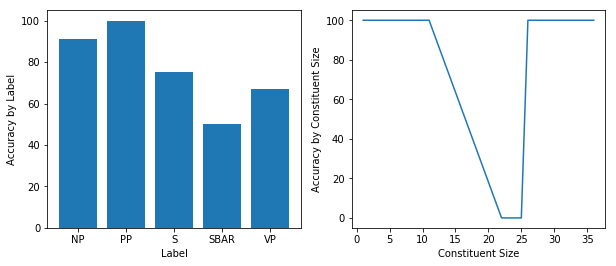

In [14]:
accuracy_plots(gold_lines, barkely_lines)

2.5 Accuracy plots for Stanford Parser 

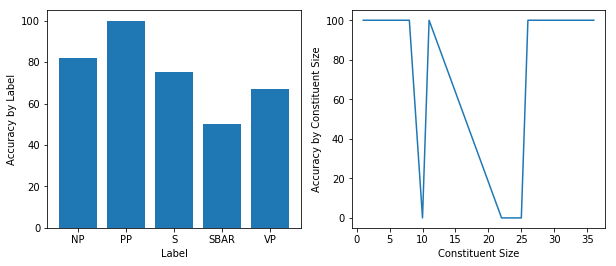

In [15]:
accuracy_plots(gold_lines, stanford_lines)

In [1]:
# Dependency Structure